# Vizualizing BigQuery data in a Jupyter notebook

[BigQuery](https://cloud.google.com/bigquery/docs/) is a petabyte-scale analytics data warehouse that you can use to run SQL queries over vast amounts of data in near realtime.

Data visualization tools can help you make sense of your BigQuery data and help you analyze the data interactively. You can use visualization tools to help you identify trends, respond to them, and make predictions using your data. In this tutorial, you use the BigQuery Python client library and pandas in a Jupyter notebook to visualize data in the BigQuery natality sample table.

## Using Jupyter magics to query BigQuery data

The BigQuery Python client library provides a magic command that allows you to run queries with minimal code.

The BigQuery client library provides a cell magic, `%%bigquery`. The `%%bigquery` magic runs a SQL query and returns the results as a pandas `DataFrame`.

In [1]:
%%bigquery
SELECT * FROM `bigquery-public-data.samples.natality` LIMIT 5

,source_year,year,month,day,wday,state,is_male,child_race,weight_pounds,plurality,...,alcohol_use,drinks_per_week,weight_gain_pounds,born_alive_alive,born_alive_dead,born_dead,ever_born,father_race,father_age,record_weight
0,2005,2005,7,NaN,3,None,False,NaN,8.628893,1,...,False,NaN,57,9.0,0.0,0.0,10,78,38,1
1,2005,2005,4,NaN,6,None,True,NaN,2.678616,1,...,False,NaN,23,7.0,0.0,0.0,8,78,39,1
2,2006,2006,5,NaN,1,None,True,NaN,11.062796,1,...,False,NaN,11,NaN,NaN,NaN,8,68,41,1
3,2007,2007,3,NaN,2,None,False,NaN,5.436599,2,...,False,NaN,10,NaN,NaN,NaN,8,78,42,1
4,2007,2007,4,NaN,7,None,False,NaN,3.560466,1,...,False,NaN,18,NaN,NaN,NaN,8,78,43,1


The following cell executes a query of the BigQuery natality public dataset and returns the total births by year.

In [2]:
%%bigquery
SELECT
    source_year AS year,
    COUNT(is_male) AS birth_count
FROM `bigquery-public-data.samples.natality`
GROUP BY year
ORDER BY year ASC

,year,birth_count
0,1969,1800103
1,1970,1868900
2,1971,1781774
3,1972,1749402
4,1973,1839736
5,1974,2029150
6,1975,2232406
7,1976,2463852
8,1977,2772206
9,1978,2865686


The following command to runs the same query, but this time the results are saved to a variable. The variable name, `total_births`, is given as an argument to the `%%bigquery`. The results can then be used for further analysis and visualization.

In [3]:
%%bigquery total_births
SELECT
    source_year AS year,
    COUNT(is_male) AS birth_count
FROM `bigquery-public-data.samples.natality`
GROUP BY year
ORDER BY year ASC

The next cell uses the pandas `DataFrame.plot` method to visualize the query results as a bar chart. See the [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/visualization.html) to learn more about data visualization with pandas.

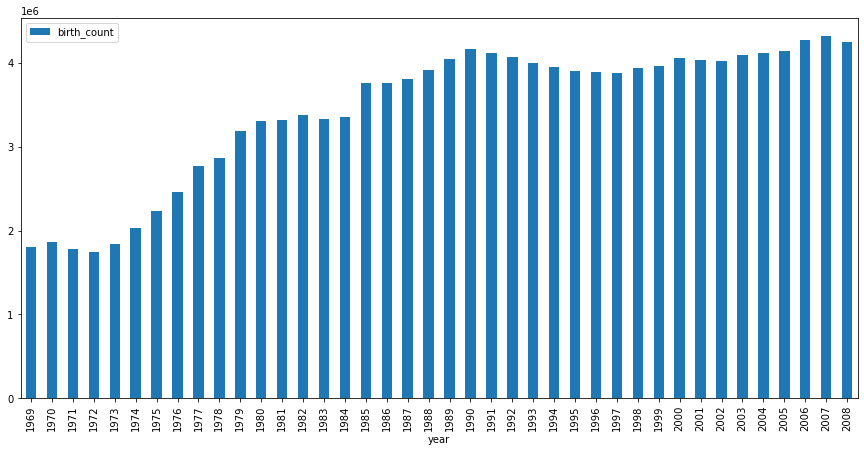

In [4]:
total_births.plot(kind='bar', x='year', y='birth_count', figsize=(15, 7));

Run the following query to retrieve the number of births by weekday. Because the `wday` (weekday) field allows null values, the query excludes records where wday is null.

In [5]:
%%bigquery births_by_weekday
SELECT
    wday,
    SUM(CASE WHEN is_male THEN 1 ELSE 0 END) AS male_births,
    SUM(CASE WHEN is_male THEN 0 ELSE 1 END) AS female_births
FROM `bigquery-public-data.samples.natality`
WHERE wday IS NOT NULL
GROUP BY wday
ORDER BY wday ASC

Visualize the query results using a line chart.

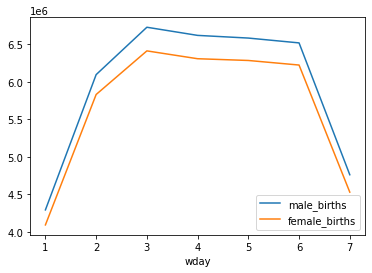

In [6]:
births_by_weekday.plot(x='wday');

## Using Python to query BigQuery data

Magic commands allow you to use minimal syntax to interact with BigQuery. Behind the scenes, `%%bigquery` uses the BigQuery Python client library to run the given query, convert the results to a pandas `Dataframe`, optionally save the results to a variable, and finally display the results. Using the BigQuery Python client library directly instead of through magic commands gives you more control over your queries and allows for more complex configurations. The library's integrations with pandas enable you to combine the power of declarative SQL with imperative code (Python) to perform interesting data analysis, visualization, and transformation tasks.

To use the BigQuery Python client library, start by importing the library and initializing a client. The BigQuery client is used to send and receive messages from the BigQuery API.

In [7]:
from google.cloud import bigquery

client = bigquery.Client()

Use the [`Client.query`](https://googleapis.github.io/google-cloud-python/latest/bigquery/generated/google.cloud.bigquery.client.Client.html#google.cloud.bigquery.client.Client.query) method to run a query. Execute the following cell to run a query to retrieve the annual count of plural births by plurality (2 for twins, 3 for triplets, etc.).

In [8]:
sql = """
SELECT
    plurality,
    COUNT(1) AS count,
    year
FROM
    `bigquery-public-data.samples.natality`
WHERE
    NOT IS_NAN(plurality) AND plurality > 1
GROUP BY
    plurality, year
ORDER BY
    count DESC
"""
df = client.query(sql).to_dataframe()
df.head()

,plurality,count,year
0,2,139209,2007
1,2,138866,2008
2,2,137239,2006
3,2,133285,2005
4,2,132344,2004


To chart the query results in your `DataFrame`, run the following cell to pivot the data and create a stacked bar chart of the count of plural births over time.

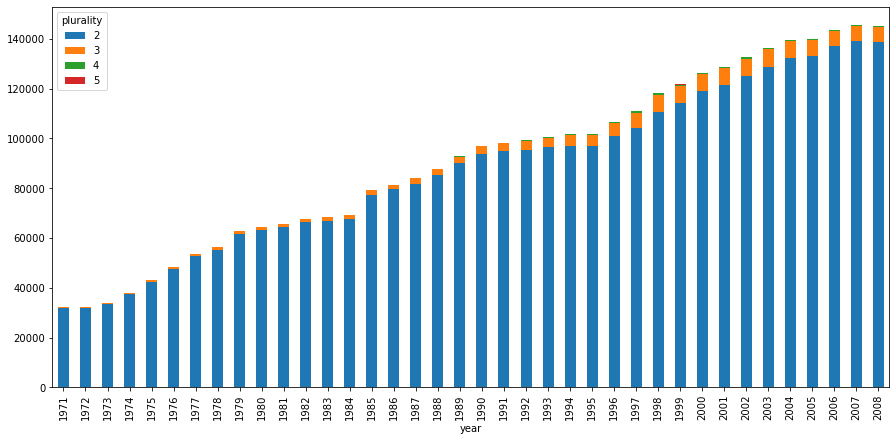

In [9]:
pivot_table = df.pivot(index='year', columns='plurality', values='count')
pivot_table.plot(kind='bar', stacked=True, figsize=(15, 7));

Run the following query to retrieve the count of births by the number of gestation weeks.

In [10]:
sql = """
SELECT
    gestation_weeks,
    COUNT(1) AS count
FROM
    `bigquery-public-data.samples.natality`
WHERE
    NOT IS_NAN(gestation_weeks) AND gestation_weeks <> 99
GROUP BY
    gestation_weeks
ORDER BY
    gestation_weeks
"""
df = client.query(sql).to_dataframe()

Finally, chart the query results in your `DataFrame`.

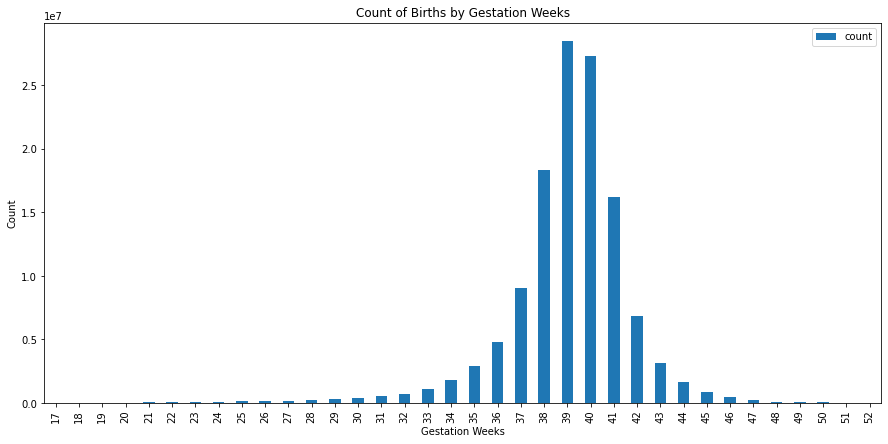

In [11]:
ax = df.plot(kind='bar', x='gestation_weeks', y='count', figsize=(15,7))
ax.set_title('Count of Births by Gestation Weeks')
ax.set_xlabel('Gestation Weeks')
ax.set_ylabel('Count');

## What's Next

+ __Learn more about writing queries for BigQuery__ — [Querying Data](https://cloud.google.com/bigquery/querying-data) in the BigQuery documentation explains how to run queries, create user-defined functions (UDFs), and more.

+ __Explore BigQuery syntax__ — The preferred dialect for SQL queries in BigQuery is standard SQL. Standard SQL syntax is described in the [SQL Reference](https://cloud.google.com/bigquery/docs/reference/standard-sql/). BigQuery's legacy SQL-like syntax is described in the [Query Reference (legacy SQL)](https://cloud.google.com/bigquery/query-reference).